In [1]:
data_dir='./data/voice/processed/'
import os
from scipy.io.wavfile import read
import pandas as pd
import matplotlib.pyplot as plt
from scipy import signal
from scipy.io import wavfile
from PIL import Image
import scipy.misc
import cv2
import librosa
from tqdm import tqdm
import numpy as np
import librosa
import librosa.display
import os
import glob
import scipy
import matplotlib.pyplot as plt
import librosa
import IPython
import cv2
from IPython.display import Audio
import soundfile as sf
from sklearn.preprocessing import StandardScaler
import tensorflow as tf
from tqdm import tqdm
cmap = plt.get_cmap('inferno')
import python_speech_features as mfcc
# data=[]
# label=[]
# file = './data/voice/final_val.csv'
# df = pd.read_csv(file)
# df = df.drop(['Unnamed: 0'],axis=1)
# df = df.drop_duplicates('ID')
# df

In [2]:
clean_data = np.load('clean_data.npy',allow_pickle=True)
clean_labels = np.load('clean_labels.npy')
noise_added = np.load('noise_added.npy')
clean_pad = np.load('clean_pad.npy')
denoised = np.load('denoised_audio.npy')

In [3]:
clean_pad[0].shape

(3872,)

(3872, 1)


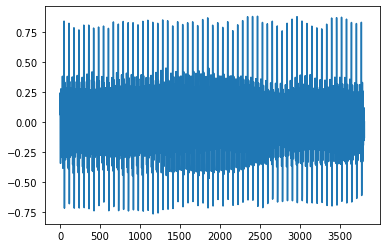

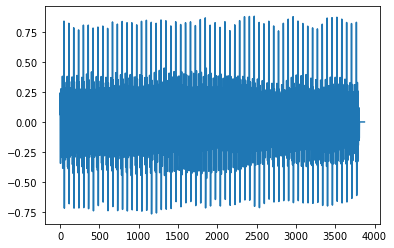

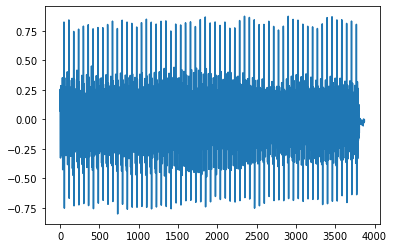

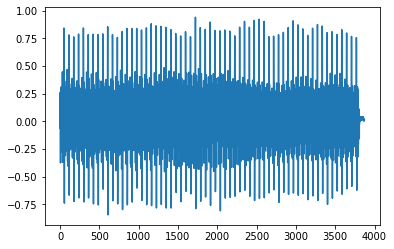

In [4]:
den = denoised[1]
print(den.shape)
plt.plot(clean_data[1])
plt.show()
plt.plot(clean_pad[1])
plt.show()
plt.plot(noise_added[1])
plt.show()
plt.plot(den)
plt.show()

# Audio(den, rate=8000)

In [5]:
# X_train.shape, X_test.shape,y_train.shape, y_test.shape 
stft_denoised=[]
for i in tqdm(denoised):
    stft_denoised.append(librosa.stft(np.reshape(i,(3872)),n_fft=2046))
stft_denoised = np.array(stft_denoised)
stft_denoised.shape

100%|████████████████████████████████████████████████████████████████████████████| 2060/2060 [00:01<00:00, 1705.91it/s]


(2060, 1024, 8)

In [6]:
stft_denoised[1].shape

(1024, 8)

C:\Users\abdul\AppData\Roaming\Python\Python37\site-packages\numpy\core\_asarray.py:85: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)


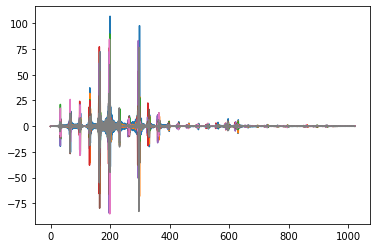

C:\Users\abdul\AppData\Roaming\Python\Python37\site-packages\numpy\core\_asarray.py:85: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)


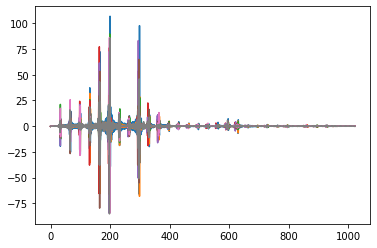

C:\Users\abdul\AppData\Roaming\Python\Python37\site-packages\numpy\core\_asarray.py:85: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)


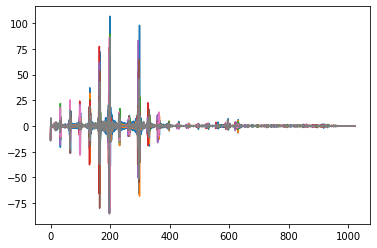

C:\Users\abdul\AppData\Roaming\Python\Python37\site-packages\numpy\core\_asarray.py:85: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)


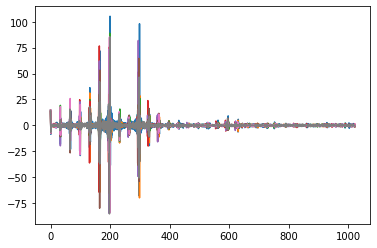

In [7]:
den = stft_denoised[1]
# print(den.shape)

plt.plot(librosa.stft(clean_data[1],n_fft=2046))
plt.show()

plt.plot(librosa.stft(clean_pad[1],n_fft=2046))
plt.show()

plt.plot(librosa.stft(noise_added[1],n_fft=2046))
plt.show()

plt.plot(den)
plt.show()

# Audio(den, rate=8000)

In [8]:
from sklearn.model_selection import train_test_split
from tensorflow.keras.utils import to_categorical
output_matrix = to_categorical(clean_labels, num_classes = 4)
X_train, X_test,y_train, y_test = train_test_split(stft_denoised,output_matrix ,
                                       random_state=98, 
                                       test_size=0.2, 
                                       shuffle=True)

In [9]:
from RES.ResNet_1DCNN import ResNet
from RES.ResNeXt_1DCNN import ResNeXt

In [14]:
length = 1024   # Number of Features (or length of the signal)
model_width = 256          # Number of Filter or Kernel in the Input Layer
num_channel = 8             # Number of Input Channels
problem_type = 'Classification' # Regression or Classification
output_number = 4 

In [16]:
tf.keras.backend.clear_session()
Regression_Model = ResNet(length, num_channel, model_width, problem_type=problem_type, output_nums=output_number).ResNet18() # Build Model
# ResNet Models supported: ResNet18, ResNet34, ResNet50, ResNet101, ResNet152, 
# Regression_Model.compile(loss='categorical_crossentropy', optimizer='adam', metrics= ['mse']) # Compile Model
# Here, Model validation metric is set as Mean Squared Error or MSE
Regression_Model.summary()
Regression_Model.compile(optimizer='adam'  ,loss='categorical_crossentropy', metrics=['acc',
                                                                              tf.keras.metrics.SensitivityAtSpecificity(0.5),
                                                                              tf.keras.metrics.SpecificityAtSensitivity(0.5),
                                                                             tf.keras.metrics.Precision()])
old =0
class myCallback(tf.keras.callbacks.Callback):
        def on_epoch_end(self,epoch,logs={}):
            global old
            if(logs.get('val_acc') > old):
                cl_model.save('voice_model_new.h5',overwrite=True)
                old = logs.get('val_acc')
                print('Epoch=',epoch,"acc = ",round(old,4),'sensitivity',
                      round(logs.get('val_sensitivity_at_specificity'),4),'specificity=',
                      round(logs.get('val_specificity_at_sensitivity'),4),'precision=',round(logs.get('val_precision'),4))
saver =myCallback()                
history = Regression_Model.fit(x=X_train,y=y_train,
                              epochs=500,
                              verbose=1,
                              batch_size=1,
                              validation_data=(X_test,y_test))#,callbacks=[saver])

Model: "functional_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 1024, 8)]    0                                            
__________________________________________________________________________________________________
conv1d (Conv1D)                 (None, 512, 256)     14592       input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization (BatchNorma (None, 512, 256)     1024        conv1d[0][0]                     
__________________________________________________________________________________________________
activation (Activation)         (None, 512, 256)     0           batch_normalization[0][0]        
_______________________________________________________________________________________

1648/1648 [==============================] - 140s 85ms/step - loss: 1.8477 - acc: 0.2888 - sensitivity_at_specificity: 0.5485 - specificity_at_sensitivity: 0.5609 - precision: 0.2870 - val_loss: 2.8974 - val_acc: 0.1869 - val_sensitivity_at_specificity: 0.4927 - val_specificity_at_sensitivity: 0.4927 - val_precision: 0.1359
Epoch 2/500
1648/1648 [==============================] - 141s 85ms/step - loss: 1.6071 - acc: 0.3034 - sensitivity_at_specificity: 0.5934 - specificity_at_sensitivity: 0.5969 - precision: 0.3117 - val_loss: 2.6730 - val_acc: 0.2985 - val_sensitivity_at_specificity: 0.5413 - val_specificity_at_sensitivity: 0.5081 - val_precision: 0.2961
Epoch 3/500
1648/1648 [==============================] - 143s 87ms/step - loss: 1.5040 - acc: 0.3252 - sensitivity_at_specificity: 0.5959 - specificity_at_sensitivity: 0.6009 - precision: 0.3584 - val_loss: 1.8214 - val_acc: 0.3180 - val_sensitivity_at_specificity: 0.5922 - val_specificity_at_sensitivity: 0.5850 - val_precision: 0.319

KeyboardInterrupt: 

In [ ]:
tf.keras.backend.clear_session()
Regression_Model = ResNeXt(length, num_channel, model_width, problem_type=problem_type, output_nums=output_number).ResNeXt18() # Build Model
# ResNet Models supported: ResNet18, ResNet34, ResNet50, ResNet101, ResNet152, 
# Regression_Model.compile(loss='categorical_crossentropy', optimizer='adam', metrics= ['mse']) # Compile Model
# Here, Model validation metric is set as Mean Squared Error or MSE
Regression_Model.summary()
Regression_Model.compile(optimizer='adam'  ,loss='categorical_crossentropy', metrics=['acc',
                                                                              tf.keras.metrics.SensitivityAtSpecificity(0.5),
                                                                              tf.keras.metrics.SpecificityAtSensitivity(0.5),
                                                                             tf.keras.metrics.Precision()])
old =0
class myCallback(tf.keras.callbacks.Callback):
        def on_epoch_end(self,epoch,logs={}):
            global old
            if(logs.get('val_acc') > old):
                cl_model.save('voice_model_new.h5',overwrite=True)
                old = logs.get('val_acc')
                print('Epoch=',epoch,"acc = ",round(old,4),'sensitivity',
                      round(logs.get('val_sensitivity_at_specificity'),4),'specificity=',
                      round(logs.get('val_specificity_at_sensitivity'),4),'precision=',round(logs.get('val_precision'),4))
saver =myCallback()                
history = Regression_Model.fit(x=X_train,y=y_train,
                              epochs=500,
                              verbose=1,
                              batch_size=1,
                              validation_data=(X_test,y_test))#,callbacks=[saver])

In [ ]:
cnn_model_input = tf.keras.layers.Input(shape=(512, 512, 3))
x=tf.keras.layers.Conv2D(64, (3, 3), activation='relu')(cnn_model_input)
x=tf.keras.layers.Conv2D(64, (3, 3), activation='relu')(x)
x=tf.keras.layers.MaxPooling2D(2, 2)(x)
x=tf.keras.layers.Conv2D(4, (3, 3), activation='relu')(x)
x=tf.keras.layers.Conv2D(4, (3, 3), activation='relu')(x)
x=tf.keras.layers.MaxPooling2D(2, 2)(x)
x=tf.keras.layers.Conv2D(32, (3, 3), activation='relu')(x)
x=tf.keras.layers.Conv2D(32, (3, 3), activation='relu')(x)
x=tf.keras.layers.MaxPooling2D(2, 2)(x)
cnn_model_out=tf.keras.layers.Flatten()(x)
cnn_model_out=tf.keras.layers.Dense(8)(x)

lin_model_input = tf.keras.layers.Input(shape=(12))
lin_model_out=tf.keras.layers.Dense(8)(lin_model_input)

merge = tf.keras.layers.Concatenate(axis=-1)([lin_model_out,cnn_model_out])
output = tf.keras.layers.Dense(4,activation='softmax')(merge)

model = tf.keras.Model(inputs=[cnn_model_input,lin_model_input], outputs=output, name="final_model")
# lin_trainX.shape,lin_trainY.shape,lin_valX.shape,lin_valY.shape
# cnn_trainX.shape,cnn_trainY.shape,cnn_valX.shape,cnn_valY.shape
model.summary()
model.compile(optimizer='adam'  ,loss='categorical_crossentropy', metrics=['acc'])

history = model.fit(x=[cnn_trainX,lin_trainX],y=cnn_trainY,
                              epochs=20,
                              verbose=1,
                              validation_data=([cnn_valX,lin_valX],cnn_valY))

In [41]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis
i
classification_models = [
    KNeighborsClassifier(4),#(3),
    SVC(kernel='linear'),#, C=0.025),
    SVC(kernel='rbf'),
    DecisionTreeClassifier(),#max_depth=5),
    RandomForestClassifier(),#max_depth=5, n_estimators=10, max_features=1),
    AdaBoostClassifier(),
    GaussianNB(),
    QuadraticDiscriminantAnalysis()]

scores = []
for model in classification_models:
    model.fit(X_train, y_train)
    score = model.score(X_test, y_test)
    model_name = type(model).__name__
    if model_name=='SVC' and model.kernel=='rbf': model_name+=' RBF kernel'
    scores.append((model_name,(f'{100*score:.2f}%')))
# Make it pretty
scores_df = pd.DataFrame(scores,columns=['Classifier','Accuracy Score'])
scores_df.sort_values(by='Accuracy Score',axis=0,ascending=False)

ValueError: Complex data not supported
[[[ 1.04670992e+01+0.00000000e+00j  9.89663315e+00+0.00000000e+00j
    9.87112141e+00+0.00000000e+00j ...  1.27105742e+01+0.00000000e+00j
    1.32443609e+01+0.00000000e+00j  1.42955847e+01+0.00000000e+00j]
  [-5.89109230e+00+2.13748804e-16j -4.51512146e+00-5.96832216e-01j
   -4.97937489e+00+5.87690234e-01j ... -6.65872622e+00+4.21497747e-02j
   -6.37788057e+00+3.87514114e-01j -7.37871408e+00+6.65729284e-01j]
  [ 1.13821411e+00-3.05762284e-17j -6.61318362e-01+2.69633383e-01j
   -8.59262645e-02-5.73369026e-01j ...  3.43340933e-01+5.78666985e-01j
   -1.33063987e-01-4.52870727e-01j -2.54739195e-01-6.12027943e-01j]
  ...
  [ 8.02112892e-02-2.38351866e-18j  1.25598192e-01+7.76425526e-02j
   -9.16602314e-02+4.97558057e-01j ... -3.21771026e-01-8.70816112e-01j
    2.04047680e-01-3.03144932e-01j  2.70314127e-01+8.84526610e-01j]
  [ 7.30685353e-01+6.72763925e-17j -8.55472505e-01+1.19729489e-01j
    2.85569370e-01-6.83539629e-01j ...  2.16854000e+00+6.42074943e-01j
   -2.30183792e+00+8.89609218e-01j  3.80474150e-01-1.22783887e+00j]
  [-1.52049184e+00+0.00000000e+00j  1.37734628e+00+0.00000000e+00j
   -5.43578625e-01+0.00000000e+00j ... -3.90817046e+00+0.00000000e+00j
    3.64340734e+00+0.00000000e+00j -1.54593050e+00+0.00000000e+00j]]

 [[ 1.06825838e+01+0.00000000e+00j  9.88310051e+00+0.00000000e+00j
    8.80948544e+00+0.00000000e+00j ...  8.83351135e+00+0.00000000e+00j
    8.91498470e+00+0.00000000e+00j  9.94870949e+00+0.00000000e+00j]
  [-5.99574947e+00+2.16775544e-16j -4.71100330e+00-7.97382295e-01j
   -4.39526367e+00-2.48319715e-01j ... -4.51741791e+00-6.07723324e-03j
   -4.23540068e+00+6.14700420e-03j -5.10098934e+00+1.03716266e+00j]
  [ 1.15964472e+00+6.40818764e-18j -5.21769166e-01+1.09258994e-01j
   -4.06187735e-02+6.50566593e-02j ...  1.41618028e-02+1.46941528e-01j
    1.15664005e-01+2.11801633e-01j -4.00739431e-01-1.38303852e+00j]
  ...
  [ 5.20050945e-03+1.18064084e-17j  7.63419690e-03-1.67132281e-02j
   -1.06317855e-01+9.34959650e-02j ...  5.41284494e-02+4.99317735e-01j
   -6.90762922e-02+1.44932136e-01j -2.51868349e-02-5.79136908e-02j]
  [ 8.09623837e-01+2.60857378e-17j -7.91479528e-01+5.34432530e-02j
    6.66927934e-01-2.23723128e-01j ... -7.45820463e-01-5.75003386e-01j
    1.20534599e+00+1.96312182e-02j -9.82193232e-01+9.15468931e-02j]
  [-1.58592558e+00+0.00000000e+00j  1.52676368e+00+0.00000000e+00j
   -1.23931503e+00+0.00000000e+00j ...  1.47499251e+00+0.00000000e+00j
   -2.08089256e+00+0.00000000e+00j  2.03005004e+00+0.00000000e+00j]]

 [[ 1.20167036e+01+0.00000000e+00j  1.26250410e+01+0.00000000e+00j
    1.37548552e+01+0.00000000e+00j ...  1.35759077e+01+0.00000000e+00j
    1.40586195e+01+0.00000000e+00j  1.39746742e+01+0.00000000e+00j]
  [-5.60483074e+00+4.45799263e-16j -6.39540768e+00+5.99948466e-01j
   -6.79643393e+00+4.97591078e-01j ... -6.64877510e+00+4.45821166e-01j
   -7.27318382e+00+3.56547236e-02j -6.92054129e+00-1.37340933e-01j]
  [-6.56280160e-01+2.80663732e-16j  2.27470681e-01-1.36624664e-01j
   -1.10623397e-01-3.04761473e-02j ... -5.91021180e-02-3.46964419e-01j
    3.38814020e-01-3.38023975e-02j -3.17099422e-01-7.97054768e-02j]
  ...
  [-8.33255231e-01-2.42716656e-16j -8.67840648e-01+2.55645975e-03j
   -4.78662640e-01-2.65084952e-01j ...  7.27798104e-01-5.25723159e-01j
    7.42985070e-01-4.25913304e-01j  3.61442715e-01+2.12457463e-01j]
  [-6.17238224e-01+2.58498468e-16j  1.42052770e+00-1.45422697e-01j
   -2.04159483e-01+6.98168457e-01j ...  6.44097507e-01+4.31081146e-01j
   -1.48868847e+00+3.49611253e-01j  1.03658624e-01-6.80016100e-01j]
  [ 1.99146581e+00+0.00000000e+00j -1.82924604e+00+0.00000000e+00j
    9.81552482e-01+0.00000000e+00j ... -1.79594743e+00+0.00000000e+00j
    1.86567497e+00+0.00000000e+00j -8.38043213e-01+0.00000000e+00j]]

 ...

 [[ 1.27720852e+01+0.00000000e+00j  1.24842224e+01+0.00000000e+00j
    1.26689672e+01+0.00000000e+00j ...  1.17288389e+01+0.00000000e+00j
    1.21274900e+01+0.00000000e+00j  1.36287928e+01+0.00000000e+00j]
  [-7.04048681e+00+1.57079719e-15j -5.66589308e+00-3.15422863e-01j
   -6.59292555e+00+4.88744825e-01j ... -5.89097023e+00+8.89485478e-02j
   -5.73324013e+00+2.47458711e-01j -7.06597996e+00+1.25268614e+00j]
  [ 1.28878701e+00+1.64943986e-15j -9.28410709e-01+1.23544373e-01j
    5.13050735e-01-4.15406197e-01j ...  1.24111831e-01-1.19274169e-01j
   -1.93399206e-01+2.20489144e-01j -1.26770332e-01-1.32988250e+00j]
  ...
  [ 1.19528043e+00-6.20423576e-16j  7.84302950e-01+7.82512724e-01j
    1.01782219e-03+7.09651530e-01j ... -4.79871213e-01+1.46292180e-01j
   -1.09239541e-01-6.63880035e-02j  2.71209091e-01-1.75060347e-01j]
  [-6.35326505e-01+4.90054247e-16j -1.32630789e+00-1.01970780e+00j
    1.06325865e+00-7.94242918e-01j ...  3.54836136e-01-1.72206342e-01j
    4.42430347e-01+5.66729605e-01j -7.60174692e-01-7.00414702e-02j]
  [-6.23749316e-01+0.00000000e+00j  1.60181129e+00+0.00000000e+00j
   -1.83854151e+00+0.00000000e+00j ... -3.06549482e-02+0.00000000e+00j
   -6.92582011e-01+0.00000000e+00j  1.34299862e+00+0.00000000e+00j]]

 [[ 8.92067051e+00+0.00000000e+00j  8.91229630e+00+0.00000000e+00j
    8.73187542e+00+0.00000000e+00j ...  7.57251644e+00+0.00000000e+00j
    7.74768925e+00+0.00000000e+00j  7.67088938e+00+0.00000000e+00j]
  [-4.51112890e+00+5.88529503e-16j -4.38091564e+00-1.76722091e-02j
   -4.54865932e+00-1.63482681e-01j ... -3.74234366e+00+1.37522370e-01j
   -4.00261450e+00+2.57485174e-02j -3.79214096e+00-9.98117030e-02j]
  [ 4.43628848e-01+3.78506599e-16j -5.91128357e-02-2.94729084e-01j
    4.86304751e-03-1.60590053e-01j ... -6.22339882e-02+5.46839610e-02j
    2.78052777e-01-1.20099351e-01j -2.67416894e-01-6.26941100e-02j]
  ...
  [-7.34137654e-01+4.23803009e-16j -5.68001032e-01-9.43794399e-02j
   -9.66700315e-02-9.56662595e-02j ... -5.65155270e-03-2.01828480e-01j
    2.39973888e-01+7.31074363e-02j  1.24208055e-01+2.62074888e-01j]
  [ 4.95815128e-02-1.26160221e-15j  7.66455114e-01+1.90983713e-01j
   -3.08680892e-01+5.46514034e-01j ... -4.19633746e-01+4.57989037e-01j
   -6.83009550e-02-4.34155390e-02j -3.78241569e-01-3.33782256e-01j]
  [ 6.87170506e-01+0.00000000e+00j -8.64062190e-01+0.00000000e+00j
    4.81410176e-01+0.00000000e+00j ...  8.33271980e-01+0.00000000e+00j
   -3.23717535e-01+0.00000000e+00j  5.99684775e-01+0.00000000e+00j]]

 [[ 1.26652231e+01+0.00000000e+00j  1.28394623e+01+0.00000000e+00j
    1.22342329e+01+0.00000000e+00j ...  1.60719929e+01+0.00000000e+00j
    1.56717062e+01+0.00000000e+00j  1.48682632e+01+0.00000000e+00j]
  [-6.81779575e+00-7.76239575e-16j -6.04714298e+00+2.53314316e-01j
   -6.79162693e+00-7.82307565e-01j ... -8.69618607e+00-2.46532992e-01j
   -7.90041304e+00-2.60127872e-01j -7.29963875e+00-4.86230969e-01j]
  [ 5.68235755e-01-1.22557917e-15j -1.41483974e+00+1.21735260e-01j
    1.73589313e+00+1.28335452e+00j ...  2.73660690e-01+1.61190546e+00j
    5.37861884e-01-6.63632035e-01j -7.11565316e-01+9.84450877e-02j]
  ...
  [ 1.15558875e+00-1.03303079e-15j  1.59402168e+00-1.82063246e+00j
    1.45914400e+00+2.11435512e-01j ... -5.16436279e-01-3.14017445e-01j
    8.70529935e-02-8.57436284e-02j -1.40102189e-02-1.26405582e-01j]
  [ 3.62503958e+00+1.60890690e-15j -2.96430326e+00+2.38035083e+00j
   -1.22031522e+00-9.66893673e-01j ...  1.90682575e-01+1.22904062e+00j
   -6.66451454e-01-2.12654024e-01j  7.50934541e-01+1.15946680e-01j]
  [-6.53809881e+00+0.00000000e+00j  4.12400150e+00+0.00000000e+00j
   -7.66799629e-01+0.00000000e+00j ...  4.31153327e-01+0.00000000e+00j
    1.08692276e+00+0.00000000e+00j -1.44908953e+00+0.00000000e+00j]]]


In [50]:
mer=[]
cl_model_inp_1 = tf.keras.layers.Input(shape=(denoised[0].shape[1],1))
x = tf.keras.layers.Conv1D(32, (3),activation='relu',strides =1,padding="same")(cl_model_inp_1)
x=tf.keras.layers.MaxPooling1D(2)(x)
x = tf.keras.layers.BatchNormalization()(x)
mer.append(x)

cl_model_inp_2 = tf.keras.layers.Input(shape=(denoised[0].shape[1],1))
x = tf.keras.layers.Conv1D(32, (3),activation='relu',strides =1,padding="same")(cl_model_inp_2)
x=tf.keras.layers.MaxPooling1D(2)(x)
x = tf.keras.layers.BatchNormalization()(x)
mer.append(x)

cl_model_inp_3 = tf.keras.layers.Input(shape=(denoised[0].shape[1],1))
x=tf.keras.layers.Conv1D(32, (3),activation='relu',strides =1,padding="same")(cl_model_inp_3)
x=tf.keras.layers.MaxPooling1D(2)(x)
x = tf.keras.layers.BatchNormalization()(x)
mer.append(x)

cl_model_inp_4 = tf.keras.layers.Input(shape=(denoised[0].shape[1],1))
x=tf.keras.layers.Conv1D(32, (3),activation='relu',strides =1,padding="same")(cl_model_inp_4)
x=tf.keras.layers.MaxPooling1D(2)(x)
x = tf.keras.layers.BatchNormalization()(x)
mer.append(x)

cl_model_inp_5 = tf.keras.layers.Input(shape=(denoised[0].shape[1],1))
x=tf.keras.layers.Conv1D(32, (3),activation='relu',strides =1,padding="same")(cl_model_inp_5)
x=tf.keras.layers.MaxPooling1D(2)(x)
x = tf.keras.layers.BatchNormalization()(x)
mer.append(x)

cl_model_inp_6 = tf.keras.layers.Input(shape=(denoised[0].shape[1],1))
x=tf.keras.layers.Conv1D(32, (3),activation='relu',strides =1,padding="same")(cl_model_inp_6)
x=tf.keras.layers.MaxPooling1D(2)(x)
x = tf.keras.layers.BatchNormalization()(x)
mer.append(x)



merge = tf.keras.layers.Concatenate(axis=-1)(mer)

x=tf.keras.layers.Conv1D(8, (3),activation='relu',strides =1,padding="same")(merge)
x=tf.keras.layers.MaxPooling1D(2)(x)
x = tf.keras.layers.BatchNormalization()(x)
x=tf.keras.layers.Conv1D(4, (3),activation='relu',strides =1,padding="same")(x)
x=tf.keras.layers.MaxPooling1D(2)(x)
x = tf.keras.layers.BatchNormalization()(x)
x=tf.keras.layers.Flatten()(x)

x=tf.keras.layers.Dense(200)(x)
x = tf.keras.layers.BatchNormalization()(x)
x =tf.keras.layers.Dropout(0.5)(x)
output = tf.keras.layers.Dense(4,activation='softmax')(x)

inp=[cl_model_inp_1,cl_model_inp_2,cl_model_inp_3,cl_model_inp_4,cl_model_inp_5,cl_model_inp_6]


model = tf.keras.Model(inputs=inp, outputs=output, name="final_model")
# lin_trainX.shape,lin_trainY.shape,lin_valX.shape,lin_valY.shape
# cnn_trainX.shape,cnn_trainY.shape,cnn_valX.shape,cnn_valY.shape
model.compile(optimizer='adam'  ,loss='categorical_crossentropy', metrics=['acc'])
model.summary()

Model: "final_model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_68 (InputLayer)           [(None, 3872, 1)]    0                                            
__________________________________________________________________________________________________
input_69 (InputLayer)           [(None, 3872, 1)]    0                                            
__________________________________________________________________________________________________
input_70 (InputLayer)           [(None, 3872, 1)]    0                                            
__________________________________________________________________________________________________
input_71 (InputLayer)           [(None, 3872, 1)]    0                                            
________________________________________________________________________________________

In [51]:
# cl_model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['acc'])
# cl_model.summary()

In [42]:
from tensorflow.keras.utils import to_categorical
output_matrix = to_categorical(clean_labels, num_classes = 4)


In [43]:
# train_clean = np.array(clean_pad[int(len(clean_pad)*0.8):])
# train_noise = np.array(noise_added[int(len(noise_added)*0.8):])
# test_clean = np.array(clean_pad[:int(len(clean_pad)*0.2)])
# test_noise = np.array(noise_added[:int(len(noise_added)*0.2)])

from sklearn.model_selection import train_test_split
F_X_train=[]
F_X_test=[]
for i in range(6):
    X_train, X_test,y_train, y_test = train_test_split(denoised[i],output_matrix ,
                                       random_state=98, 
                                       test_size=0.2, 
                                       shuffle=False)
    F_X_train.append(X_train)
    F_X_test.append(X_test)

((1648, 4), (412, 4), (6, 412, 3872, 1), (6, 1648, 3872, 1))

In [45]:
from tensorflow.keras.utils import plot_model
# plot_model(cl_model, to_file='cl_model.png', show_shapes=True, show_layer_names=True)
# F_y_train

In [52]:
history = model.fit(x=F_X_train,y=np.array(y_train),
                              epochs=150,
                              verbose=1,
                              batch_size=32,
                              validation_data=(F_X_test,np.array(y_test)))#,callbacks=[saver])

Epoch 1/150
52/52 [==============================] - 3s 58ms/step - loss: 1.9516 - acc: 0.3525 - val_loss: 2.9484 - val_acc: 0.0777
Epoch 2/150
52/52 [==============================] - 3s 50ms/step - loss: 1.2214 - acc: 0.5316 - val_loss: 3.2084 - val_acc: 0.0777
Epoch 3/150
52/52 [==============================] - 3s 50ms/step - loss: 0.9898 - acc: 0.6195 - val_loss: 3.8436 - val_acc: 0.0777
Epoch 4/150
42/52 [=======================>......] - ETA: 0s - loss: 0.8285 - acc: 0.6927

KeyboardInterrupt: 

In [38]:
import librosa.display
from matplotlib.backends.backend_agg import FigureCanvasAgg as FigureCanvas

path = './data/voice/UNETPP_denoised/'
if not os.path.exists(path):
    os.mkdir(path)
for j in range(6):
    for i in tqdm(range(len(denoised[j]))):
        samp = np.reshape(denoised[j][i],(denoised[j][i].shape[0]))
        
#         y=clean_labels[i]
    #     path = './data/voice/mfcc/'+i+'.png'
        mfccs = librosa.stft(samp)
    #     mfccs = librosa.feature.mfcc(samp, sr=8000,n_mfcc=12)
        noise_stft_mag ,noisy_stft_phase=librosa.magphase(mfccs)
        noisy_signal_stft_unscaled_magnitude=librosa.amplitude_to_db(noise_stft_mag, ref=np.max)
        mfccs = (noisy_signal_stft_unscaled_magnitude)




        fig = plt.Figure()
        canvas = FigureCanvas(fig)
        ax = fig.add_subplot(111)
        librosa.display.specshow(mfccs, sr=8000, x_axis='time',ax = ax)

        y=clean_labels[i]

        ax.axis('off')

        if not os.path.exists(path+str(y)):
            os.mkdir(path+str(y))
        fig.savefig(f'./{path+str(y)}/{j}_{i}.png',bbox_inches='tight',pad_inches = 0,dpi=200)

    

100%|██████████████████████████████████████████████████████████████████████████████| 2060/2060 [02:14<00:00, 15.28it/s]
